#  План семинара

1. Линейный классификатор в задаче бинарной классификации
2. Кодирование категориальных признаков

## Задача бинарной классификации

### Логистическая регрессия

y = {-1, 1}

$b(x) = \sigma(<w,x>)$,

где $\sigma(z) = \frac{1}{1 + e^{-z}}$

То есть, мы предсказываем $P(y_i = 1| X_i)$ - вероятность того, что наблюдение принадлежит классу +1

Обучаем с помощью функционала: Максимального лог правдоподобия (флэшбек из статистики)

$Q(w) = -\Sigma_{i=0}^{n}(y_i*log(b(x_i)) + (1 - y_i)log(1 - b(x_i))) \rightarrow min_w$



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
np.random.seed(42)

In [3]:
data = pd.read_csv( "./bike_buyers_clean.csv")

In [4]:
data

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000,1,Bachelors,Skilled Manual,Yes,0,0-1 Miles,Europe,42,No
1,24107,Married,Male,30000,3,Partial College,Clerical,Yes,1,0-1 Miles,Europe,43,No
2,14177,Married,Male,80000,5,Partial College,Professional,No,2,2-5 Miles,Europe,60,No
3,24381,Single,Male,70000,0,Bachelors,Professional,Yes,1,5-10 Miles,Pacific,41,Yes
4,25597,Single,Male,30000,0,Bachelors,Clerical,No,0,0-1 Miles,Europe,36,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000,2,High School,Professional,Yes,2,2-5 Miles,North America,54,Yes
996,28672,Single,Male,70000,4,Graduate Degree,Professional,Yes,0,2-5 Miles,North America,35,Yes
997,11809,Married,Male,60000,2,Bachelors,Skilled Manual,Yes,0,0-1 Miles,North America,38,Yes
998,19664,Single,Male,100000,3,Bachelors,Management,No,3,1-2 Miles,North America,38,No


# Обзор данных

In [5]:
# проверим типы колонок в датасете
data.dtypes

ID                   int64
Marital Status      object
Gender              object
Income               int64
Children             int64
Education           object
Occupation          object
Home Owner          object
Cars                 int64
Commute Distance    object
Region              object
Age                  int64
Purchased Bike      object
dtype: object

In [6]:
X = data.iloc[:,:-1]
X.drop(columns='ID', inplace=True)

y = data['Purchased Bike']

In [7]:
y.value_counts()

Purchased Bike
No     519
Yes    481
Name: count, dtype: int64

In [8]:
num_cols = X.columns[X.dtypes == 'int64'].tolist()
cat_cols = X.columns[X.dtypes == 'object']

print(f"We have {len(num_cols)} numeric columns: {', '.join(num_cols)}")
print(f"And {len(cat_cols)} categorical columns: {', '.join(cat_cols)}")

We have 4 numeric columns: Income, Children, Cars, Age
And 7 categorical columns: Marital Status, Gender, Education, Occupation, Home Owner, Commute Distance, Region


In [9]:
for col in cat_cols:
    print(col)
    display(X[col].value_counts(normalize=True))
    print()

Marital Status


Marital Status
Married    0.539
Single     0.461
Name: proportion, dtype: float64


Gender


Gender
Male      0.509
Female    0.491
Name: proportion, dtype: float64


Education


Education
Bachelors              0.306
Partial College        0.265
High School            0.179
Graduate Degree        0.174
Partial High School    0.076
Name: proportion, dtype: float64


Occupation


Occupation
Professional      0.276
Skilled Manual    0.255
Clerical          0.177
Management        0.173
Manual            0.119
Name: proportion, dtype: float64


Home Owner


Home Owner
Yes    0.685
No     0.315
Name: proportion, dtype: float64


Commute Distance


Commute Distance
0-1 Miles     0.366
5-10 Miles    0.192
1-2 Miles     0.169
2-5 Miles     0.162
10+ Miles     0.111
Name: proportion, dtype: float64


Region


Region
North America    0.508
Europe           0.300
Pacific          0.192
Name: proportion, dtype: float64

In [10]:
# у нас есть категориальные переменные разных видов!

binary_cols = cat_cols[X[cat_cols].nunique() == 2].tolist()
ordinal_cols = ['Commute Distance', 'Education']
cat_cols = cat_cols.difference(binary_cols + ordinal_cols).tolist()

In [11]:
binary_cols 

['Marital Status', 'Gender', 'Home Owner']

In [12]:
for col in num_cols:
    print(col)
    display(X[col].describe())
    print()

Income


count      1000.000000
mean      56140.000000
std       31081.609779
min       10000.000000
25%       30000.000000
50%       60000.000000
75%       70000.000000
max      170000.000000
Name: Income, dtype: float64


Children


count    1000.000000
mean        1.908000
std         1.626094
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: Children, dtype: float64


Cars


count    1000.000000
mean        1.452000
std         1.124705
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Cars, dtype: float64


Age


count    1000.000000
mean       44.190000
std        11.353537
min        25.000000
25%        35.000000
50%        43.000000
75%        52.000000
max        89.000000
Name: Age, dtype: float64

In [13]:
X.describe()

,Income,Children,Cars,Age
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,56140.000000,1.908000,1.452000,44.190000
std,31081.609779,1.626094,1.124705,11.353537
min,10000.000000,0.000000,0.000000,25.000000
25%,30000.000000,0.000000,1.000000,35.000000
50%,60000.000000,2.000000,1.000000,43.000000
75%,70000.000000,3.000000,2.000000,52.000000
max,170000.000000,5.000000,4.000000,89.000000


In [14]:
# classes are balanced !
y.value_counts(normalize=True)

Purchased Bike
No     0.519
Yes    0.481
Name: proportion, dtype: float64

In [15]:
# transform y to numeric column
y = (y == 'Yes').astype(int)
y

0      0
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    0
999    1
Name: Purchased Bike, Length: 1000, dtype: int64

# Подготовка данных

## Кодирование категориальных признаков

In [16]:
# run if not installed yet

!pip install category_encoders

In [17]:
from category_encoders.ordinal import OrdinalEncoder # LabelEncoder
from category_encoders.one_hot import OneHotEncoder # OneHotEncoding
from category_encoders.target_encoder import TargetEncoder # счетчики+сглаживание

In [18]:
X['Education'].unique()
dict_our = {'Bachelors':2, 'Partial College':1}
X['Education'].map(dict_our)

0      2.0
1      1.0
2      1.0
3      2.0
4      2.0
      ... 
995    NaN
996    NaN
997    2.0
998    2.0
999    NaN
Name: Education, Length: 1000, dtype: float64

In [19]:
X['Education']

0            Bachelors
1      Partial College
2      Partial College
3            Bachelors
4            Bachelors
            ...       
995        High School
996    Graduate Degree
997          Bachelors
998          Bachelors
999        High School
Name: Education, Length: 1000, dtype: object

In [20]:
# Ordinal: from categories to numbers

ord_enc = OrdinalEncoder()
ord_enc.fit_transform(X['Education'])

,Education
0,1
1,2
2,2
3,1
4,1
...,...
995,3
996,5
997,1
998,1


In [21]:
# One hot: from k categories to k dummy columns

one_hot_enc = OneHotEncoder()

one_hot_enc.fit_transform(X['Education'], drop='first')
# * fit -> определить количество новых столбцов (по кол-ву категорий)
# * transform -> создать новые столбцы
# * fit_transform = fit + transform

# Нужно ли удалять какую-то из колонок после такого кодирования ?


,Education_1,Education_2,Education_3,Education_4,Education_5
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
995,0,0,1,0,0
996,0,0,0,0,1
997,1,0,0,0,0
998,1,0,0,0,0


Target encoding вычисляет значения по формуле

$$\frac{mean(target)\cdot n_{rows} + \alpha \cdot globalMean}{n_{rows} + \alpha} $$

In [22]:
data.columns

Index(['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education',
       'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Age',
       'Purchased Bike'],
      dtype='object')

In [23]:
df = X.copy()
df['y'] = y

In [24]:
df.groupby('Education')['y'].mean()

Education
Bachelors              0.552288
Graduate Degree        0.540230
High School            0.441341
Partial College        0.449057
Partial High School    0.263158
Name: y, dtype: float64

In [25]:
df[['Education', 'y']].head()

,Education,y
0,Bachelors,0
1,Partial College,0
2,Partial College,0
3,Bachelors,1
4,Bachelors,1


In [26]:
# target encoding: from k categories to posterior probabilites of y == 1 - P(y==1 | category == c1)

tgt_enc = TargetEncoder(smoothing=1)

# smoothing - это коэффициент сглаживания alpha, чем он больше, тем больше регуляризация

tgt_enc.fit_transform(X['Education'], y)

,Education
0,0.552288
1,0.449057
2,0.449057
3,0.552288
4,0.552288
...,...
995,0.441341
996,0.540230
997,0.552288
998,0.552288


In [27]:
# энкодер можно применять сразу на весь датафрейм

tgt_enc = TargetEncoder(cols=['Education', 'Gender', 'Region'])
tgt_enc.fit_transform(X, y)

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,0.486762,40000,1,0.552288,Skilled Manual,Yes,0,0-1 Miles,0.493333,42
1,Married,0.475442,30000,3,0.449057,Clerical,Yes,1,0-1 Miles,0.493333,43
2,Married,0.475442,80000,5,0.449057,Professional,No,2,2-5 Miles,0.493333,60
3,Single,0.475442,70000,0,0.552288,Professional,Yes,1,5-10 Miles,0.588542,41
4,Single,0.475442,30000,0,0.552288,Clerical,No,0,0-1 Miles,0.493333,36
...,...,...,...,...,...,...,...,...,...,...,...
995,Married,0.475442,60000,2,0.441341,Professional,Yes,2,2-5 Miles,0.433071,54
996,Single,0.475442,70000,4,0.540230,Professional,Yes,0,2-5 Miles,0.433071,35
997,Married,0.475442,60000,2,0.552288,Skilled Manual,Yes,0,0-1 Miles,0.433071,38
998,Single,0.475442,100000,3,0.552288,Management,No,3,1-2 Miles,0.433071,38


Помимо сглаживания, для борьбы с переобучением при таргет энкодинге в лекции предлагались и другие методы

- Добавление случайного шума
- Вычисление счетчиков на кросс-валидации
- Expanding mean encoding

Первые две идеи реализованы в классе LeaveOneOut

- значения считаются на основе кросс-валидации вида leave one out (то есть значение энкодинга для конкретного наблюдения будет считаться по всем наблюдениям, кроме этого)
- параметр sigma отвечает за дисперсию случайного шума, который добавляется к значению энкодинга (чем больше sigma, тем больше регуляризация)

In [28]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

loo_enc = LeaveOneOutEncoder(sigma=3.)

loo_enc.fit_transform(X['Education'], y)

,Education
0,1.379784
1,0.263787
2,1.326609
3,3.067564
4,0.163891
...,...
995,0.068666
996,3.436731
997,1.609786
998,-0.395370


## Масштабирование числовых признаков

<Axes: >

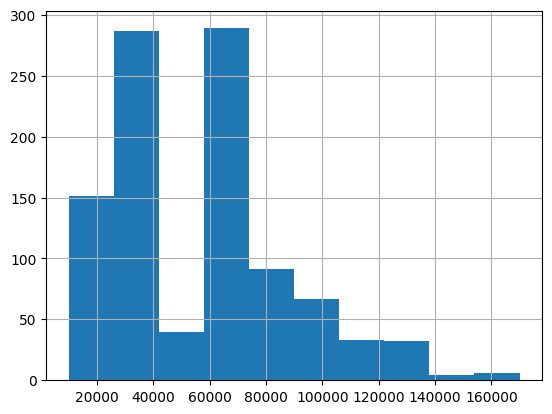

In [29]:
X['Income'].hist()

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(X[['Income']])

array([[-0.51953796],
       [-0.8414326 ],
       [ 0.76804062],
       [ 0.44614598],
       [-0.8414326 ],
       [-1.48522189],
       [ 3.34319779],
       [-0.51953796],
       [-1.16332725],
       [-1.16332725],
       [-0.8414326 ],
       [ 1.08993527],
       [ 3.66509243],
       [-0.51953796],
       [ 0.12425133],
       [-1.48522189],
       [-0.8414326 ],
       [-0.8414326 ],
       [-0.51953796],
       [-1.16332725],
       [-0.51953796],
       [ 0.76804062],
       [-0.51953796],
       [ 0.76804062],
       [-0.51953796],
       [-0.8414326 ],
       [-0.8414326 ],
       [ 1.41182991],
       [ 0.44614598],
       [-1.16332725],
       [-1.16332725],
       [-1.48522189],
       [-1.16332725],
       [ 0.76804062],
       [ 1.08993527],
       [-1.48522189],
       [-1.48522189],
       [-0.8414326 ],
       [-1.16332725],
       [-1.48522189],
       [-0.8414326 ],
       [-0.51953796],
       [-1.48522189],
       [ 3.66509243],
       [-1.16332725],
       [-1

Есть две проблемы:
- класc StandardScaler умеет работать только на части колонок датафрейма
- классы sklearn возвращают numpy arrays, а не pandas dataframe, что не удобно

In [31]:
num_cols

['Income', 'Children', 'Cars', 'Age']

In [32]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('scaler', StandardScaler(), num_cols)], remainder='passthrough') # 'drop'

In [33]:
ct.fit_transform(X)

array([[-0.5195379574051056, -0.5586728696623785, -1.2916513760469168,
        ..., 'Yes', '0-1 Miles', 'Europe'],
       [-0.8414326026375131, 0.6718841119728166, -0.4020843126537234,
        ..., 'Yes', '0-1 Miles', 'Europe'],
       [0.7680406235245242, 1.9024410936080116, 0.48748275073947, ...,
        'No', '2-5 Miles', 'Europe'],
       ...,
       [0.12425133305970927, 0.05660562115521903, -1.2916513760469168,
        ..., 'Yes', '0-1 Miles', 'North America'],
       [1.4118299139893389, 0.6718841119728166, 1.3770498141326635, ...,
        'No', '1-2 Miles', 'North America'],
       [0.12425133305970927, 0.6718841119728166, 0.48748275073947, ...,
        'Yes', '10+ Miles', 'North America']],
      shape=(1000, 11), dtype=object)

In [34]:
# нет удобной реализации - напишем сами !

from sklearn.base import TransformerMixin

class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or StandardScaler()

    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [35]:
sc = CustomScaler(num_cols)
X2 = sc.fit_transform(X)

In [36]:
X2

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,Female,-0.519538,-0.558673,Bachelors,Skilled Manual,Yes,-1.291651,0-1 Miles,Europe,-0.192988
1,Married,Male,-0.841433,0.671884,Partial College,Clerical,Yes,-0.402084,0-1 Miles,Europe,-0.104866
2,Married,Male,0.768041,1.902441,Partial College,Professional,No,0.487483,2-5 Miles,Europe,1.393214
3,Single,Male,0.446146,-1.173951,Bachelors,Professional,Yes,-0.402084,5-10 Miles,Pacific,-0.281110
4,Single,Male,-0.841433,-1.173951,Bachelors,Clerical,No,-1.291651,0-1 Miles,Europe,-0.721722
...,...,...,...,...,...,...,...,...,...,...,...
995,Married,Male,0.124251,0.056606,High School,Professional,Yes,0.487483,2-5 Miles,North America,0.864480
996,Single,Male,0.446146,1.287163,Graduate Degree,Professional,Yes,-1.291651,2-5 Miles,North America,-0.809844
997,Married,Male,0.124251,0.056606,Bachelors,Skilled Manual,Yes,-1.291651,0-1 Miles,North America,-0.545477
998,Single,Male,1.411830,0.671884,Bachelors,Management,No,1.377050,1-2 Miles,North America,-0.545477


# Соберем все преобразования данных в pipeline

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

p1 = Pipeline([
    ('ordinal_encoder_', OrdinalEncoder(cols=ordinal_cols + binary_cols + cat_cols)), # плохо!!!
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
    ])

p2 = Pipeline([
    ('one_hot_encoder_', OneHotEncoder(cols=ordinal_cols + binary_cols+cat_cols)),
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
    ])

p3 = Pipeline([
    ('target_encoder_', TargetEncoder(cols=ordinal_cols + binary_cols+cat_cols)),
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
])

p4 = Pipeline([
    ('ordinal_encoder_', OrdinalEncoder(cols=ordinal_cols)),
    ('one_hot_encoder_', OneHotEncoder(cols=binary_cols+cat_cols)),
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
    ])

p5 = Pipeline([
    ('ordinal_encoder_', OrdinalEncoder(cols=ordinal_cols)),
    ('one_hot_encoder_', OneHotEncoder(cols=binary_cols)),
    ('target_encoder_', TargetEncoder(cols=cat_cols)),
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
])

p6 = Pipeline([
    ('one_hot_encoder_', OneHotEncoder(cols=binary_cols)),
    ('target_encoder_', TargetEncoder(cols=cat_cols + ordinal_cols)),
    ('scaler_', CustomScaler(num_cols)),
    ('model_', LogisticRegression())
])

In [48]:
ordinal_cols, binary_cols, cat_cols

(['Commute Distance', 'Education'],
 ['Marital Status', 'Gender', 'Home Owner'],
 ['Occupation', 'Region'])

In [39]:
p1

Pipeline(steps=[('ordinal_encoder_',
                 OrdinalEncoder(cols=['Commute Distance', 'Education',
                                      'Marital Status', 'Gender', 'Home Owner',
                                      'Occupation', 'Region'])),
                ('scaler_', <__main__.CustomScaler object at 0x118d45f40>),
                ('model_', LogisticRegression())])

In [40]:
# пример работы с пайплайном
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y)

p1.fit(X_train, y_train)

#print(p1)

y_pred = p1.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.632


In [41]:
for i in [p1, p2, p3, p4, p5, p6]:
    i.fit(X_train, y_train)
    y_pred = i.predict(X_test)
    print(accuracy_score(y_test, y_pred))

0.632
0.624
0.652
0.636
0.624
0.616


In [42]:
# Можно и не совсем бинарную классификацию :)

#from sklearn import svm, datasets
#from sklearn.model_selection import cross_val_score
#X, y = datasets.load_iris(return_X_y=True)
#clf = LogisticRegression(max_iter=int(1e5))
#cross_val_score(clf, X, y, cv=5, scoring='accuracy')

In [43]:
# X, y

# Сравнение качества классификации при разных пайплайнах преобразования данных

Вообще существует довольно большое количество метрик для задачи бинарной классификации (о них будет подробно рассказано на лекциях)

Но для нашей задачи разберем самую простую и интуитивную метрику: accuracy

$accuracy = \frac{1}{n}\Sigma_{i=0}^n [\hat y_i == y_i]$

То есть доля правильных предсказаний

In [ ]:
from sklearn.model_selection import cross_validate
import warnings

warnings.filterwarnings('ignore')

In [47]:
for i, pipe in enumerate([p1, p2, p3, p4, p5, p6]):
    cv_res = cross_validate(pipe,
                            X,
                            y,
                            cv=5,
                            scoring='accuracy'
                           )
    print(f"Pipeline {i + 1}: mean cv accuracy = {cv_res['test_score'].mean()}")
    print(cv_res['test_score'])

Pipeline 1: mean cv accuracy = 0.606
[0.535 0.59  0.575 0.685 0.645]
Pipeline 2: mean cv accuracy = 0.617
[0.575 0.59  0.605 0.685 0.63 ]
Pipeline 3: mean cv accuracy = 0.629
[0.585 0.65  0.6   0.665 0.645]
Pipeline 4: mean cv accuracy = 0.6180000000000001
[0.595 0.605 0.59  0.66  0.64 ]
Pipeline 5: mean cv accuracy = 0.6319999999999999
[0.6   0.635 0.575 0.68  0.67 ]
Pipeline 6: mean cv accuracy = 0.6140000000000001
[0.59  0.635 0.56  0.65  0.635]


In [50]:
p5.predict_proba(X_test)

array([[0.43122511, 0.56877489],
       [0.35253293, 0.64746707],
       [0.76103922, 0.23896078],
       [0.60450502, 0.39549498],
       [0.39033348, 0.60966652],
       [0.60089251, 0.39910749],
       [0.54519327, 0.45480673],
       [0.25613283, 0.74386717],
       [0.71582557, 0.28417443],
       [0.64375659, 0.35624341],
       [0.70239715, 0.29760285],
       [0.65982297, 0.34017703],
       [0.64711182, 0.35288818],
       [0.71133665, 0.28866335],
       [0.44909184, 0.55090816],
       [0.44216748, 0.55783252],
       [0.58813594, 0.41186406],
       [0.58020858, 0.41979142],
       [0.69804784, 0.30195216],
       [0.41928458, 0.58071542],
       [0.50979808, 0.49020192],
       [0.56609234, 0.43390766],
       [0.6591957 , 0.3408043 ],
       [0.72946457, 0.27053543],
       [0.58082844, 0.41917156],
       [0.49972886, 0.50027114],
       [0.60144066, 0.39855934],
       [0.77221533, 0.22778467],
       [0.65157655, 0.34842345],
       [0.4425388 , 0.5574612 ],
       [0.

In [ ]:
p5.fit(X, y)

Pipeline(steps=[('ordinal_encoder_',
                 OrdinalEncoder(cols=['Commute Distance', 'Education'],
                                mapping=[{'col': 'Commute Distance',
                                          'data_type': dtype('O'),
                                          'mapping': 0-1 Miles     1
2-5 Miles     2
5-10 Miles    3
1-2 Miles     4
10+ Miles     5
NaN          -2
dtype: int64},
                                         {'col': 'Education',
                                          'data_type': dtype('O'),
                                          'mapping': Bachelors              1
Partial College        2
High School            3
Partial High School    4
Graduate Degree        5
NaN                   -2
dtype: int64}])),
                ('one_hot_encoder_',
                 OneHotEncoder(cols=['Marital Status', 'Gender',
                                     'Home Owner'])),
                ('target_encoder_',
                 TargetEncoder(cols=['Occupation', 'Region'])),
                ('scaler_', <__main__.CustomScaler object at 0x1199608c0>),
                ('model_', LogisticRegression())])